### Метрики энкодера на основе Resnet18.  
#### Выходной слой: *nn.Linear(in_features=512, out_features=1024, bias=True)*

### Визуализация в 3 ГК помимо того что не дает колличественных оценок точности энкодера, так и несет в себе в лучшем случае около 40% информации от выходного вектора длинной 1024. 

###  Необходимо ознакомится с метриками и оценками модели энкодера. исп.:
* kMeans
* OneClass SVM
* Gaussian Mixture

### Конечная цель: оценка целесообразности применения энкодера в рамках *данной* задачи.

Что откуда качать:

* https://drive.google.com/file/d/1-oIPyg3uFT1n--MXyR4Uzx95YqR3NsNT/view?usp=sharing - дополнительные знаки - не референсные. Часть из них - вырезка из видосов, часть - собранно ручками. Разместить в папке *data/additional_sign/*
* https://drive.google.com/file/d/1-rTwhmdUdcuPMYz8BiPQV3fiWCSJjE20/view?usp=sharing - *last_encoder_1024_98* - веса энкодера. Разместить в папке с ноутбуком.
* https://drive.google.com/file/d/1-K3ee1NbMmx_0T5uwMesStmKnZO_6mWi/view?usp=sharing - rtds с csv, содержащей инфу. Разместить в папке *data*: data/R_MERGED/.. и data/RTDS_DATASET.csv.
* https://drive.google.com/file/d/1-l3VvU-WtSoXbW_AaTFUreVD-tgXV8Q0/view?usp=sharing - стоковые знаки. Используются как референс, то есть объеденяются с rtds с пометкой 'train'. Разместить так: data/STOCK_SIGNS.

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
import pandas as pd
import os
import pathlib
import cv2
import sys
from datetime import datetime
from tqdm.notebook import trange, tqdm
from sklearn.preprocessing import LabelEncoder


TEXT_COLOR = 'black'
# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
%matplotlib inline
plt.rcParams["figure.figsize"] = (17,10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [140]:
PROJECT_ROOT = pathlib.Path('..').resolve()
    
DATA_DIR = PROJECT_ROOT / 'data'
SRC_PATH = str(PROJECT_ROOT / 'src')

if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)
    
torch.set_grad_enabled(False)

In [141]:
from torchvision.models import resnet
encoder = resnet.resnet18(pretrained=True)
encoder.fc = nn.Linear(in_features=512, out_features=512, bias=True)
r = encoder.load_state_dict(torch.load('encoder_loss_0.00056_acc_0.993')['model'])
encoder.eval()
encoder.to(device)
assert r

### Этап 1.1. Берем RTDS, из него берем *train* как *baseline*. Заменяем *valid* на *test*.

In [143]:
DATASET_PREFIX = DATA_DIR / 'ENCODER_DATASET'
RTDS_DF = pd.read_csv(DATASET_PREFIX / 'WIDE_DATASET_4_ENCODER.csv')
RTDS_DF['filepath'] = RTDS_DF['filepath'].apply(lambda x: str(DATASET_PREFIX / x))
RTDS_DF.drop_duplicates(subset=['filepath'], inplace=True)
RTDS_DF['set'] = RTDS_DF['set'].apply(lambda x: 'test' if x == 'valid' else x)

TARGET_SIGNS = [
        '1.1', '1.6', '1.8', '1.22', '1.31', '1.33', 
        '2.1', '2.2', '2.3', '2.4', '2.5', 
        '3.1', '3.18', '3.20', '3.21', '3.22', '3.23', '3.24',
        '3.25', '3.27', '3.28', '3.31', 
        '4.1.1', '4.3', 
        '5.5', '5.6', '5.16', 
        '5.19.1', '5.20', 
        '6.3.2', '6.4', 
        '7.3', '7.4'
    ]

RTDS_DF = RTDS_DF[RTDS_DF['sign'].isin(TARGET_SIGNS)]

### *train* как референс, *valid* - query для валидации.
### Этап 1.2. Формируем DataFrame отсутствущих знаков в RTDS.

In [144]:

le = LabelEncoder()

included_signs = sorted(set(RTDS_DF.sign))
print('Included signs in ENCODER_DATASET:', included_signs)
not_included_signs = sorted(set(TARGET_SIGNS) - set(RTDS_DF.sign))
print('Not included in ENCODER_DATASET:', not_included_signs)

print('Getting aditional sings...')
additional_DF = pd.DataFrame(columns=RTDS_DF.columns)

encode_offset = max(set(RTDS_DF['encoded'])) + 1
files = os.listdir(DATA_DIR / 'additional_sign')

skipped_signs = []

row_list = []
for file in files:
    sign = file.split('_')[0]
     
    if sign.rsplit('.', 1)[0] == '3.25':
        sign = '3.25'
        
    if sign.rsplit('.', 1)[0] == '3.24':
        sign = '3.24'         

    if sign in included_signs:
        skipped_signs.append(sign)
        continue
        
    row = {'filepath': str(DATA_DIR / 'additional_sign' / file), 
           'sign': sign, 
           'set': 'test',
           'encoded': None
          }

    row_list.append(row)

print('Skipped signs:', skipped_signs)
additional_DF = pd.DataFrame(row_list, columns=RTDS_DF.columns)
additional_DF.encoded = le.fit_transform(additional_DF.sign) + len(set(RTDS_DF.encoded))

print('Including part of additional_DF for:', sorted(set(additional_DF.sign)), 'sign.')
additional_DF = additional_DF[~additional_DF['sign'].isin(RTDS_DF['sign'])]

RTDS_DF = pd.concat([RTDS_DF, additional_DF], ignore_index=True)

Included signs in ENCODER_DATASET: ['1.1', '1.22', '1.33', '1.8', '2.1', '2.2', '2.3', '2.4', '2.5', '3.1', '3.18', '3.20', '3.21', '3.22', '3.23', '3.24', '3.25', '3.27', '3.28', '3.31', '4.1.1', '4.3', '5.16', '5.19.1', '5.20', '5.5', '5.6', '6.4', '7.3', '7.4']
Not included in ENCODER_DATASET: ['1.31', '1.6', '6.3.2']
Getting aditional sings...
Skipped signs: ['3.24', '3.25', '2.4', '3.23', '3.25', '3.21', '3.25', '3.24', '3.24', '3.25', '3.31', '3.24', '2.4', '3.25', '3.24', '2.4', '3.31', '3.24', '3.24', '3.22', '3.24', '2.4', '3.31', '3.24', '3.25', '2.4', '3.23', '3.25', '3.21', '3.24', '3.21', '3.31', '3.21', '3.24', '3.23', '3.31', '3.31', '3.31', '3.24', '3.24', '3.31', '3.24', '3.25', '3.21', '3.31']
Including part of additional_DF for: ['1.31', '1.6', '6.3.2'] sign.


In [145]:
print('So we got', len(set(RTDS_DF['sign'])), 'signs. Assume == 33')
LABEL_DICT = dict(zip(RTDS_DF.sign, RTDS_DF.encoded))

So we got 33 signs. Assume == 33


In [146]:
centroid_from_train_for_signs = sorted(set(RTDS_DF.loc[RTDS_DF['set'] == 'train', 'sign']))
print('We will get centroids from TRAIN for', centroid_from_train_for_signs)
centroid_from_stock_for_signs = sorted(set(TARGET_SIGNS) - set(centroid_from_train_for_signs))
print('We should get centroids from STOCK signs for', centroid_from_stock_for_signs)


We will get centroids from TRAIN for ['1.1', '1.22', '1.33', '1.8', '2.1', '2.2', '2.3', '2.4', '2.5', '3.1', '3.18', '3.20', '3.21', '3.22', '3.23', '3.24', '3.25', '3.27', '3.28', '3.31', '4.1.1', '4.3', '5.16', '5.19.1', '5.20', '5.5', '5.6', '6.4', '7.3', '7.4']
We should get centroids from STOCK signs for ['1.31', '1.6', '6.3.2']


### Этап 2. Формируем для отсутствующих~=**ДЛЯ ВСЕХ** знаков baseline из образцовых знаков с википедии.

In [147]:
STOCK_SIGNS_CSV_LOCATION = DATA_DIR / 'STOCK_SIGNS/STOCK_SIGNS.csv'
STOCK_SIGNS_DATAFRAME = pd.read_csv(STOCK_SIGNS_CSV_LOCATION)
STOCK_SIGNS_DATAFRAME.rename({'SIGN': 'sign'}, axis='columns', inplace=True)

STOCK_SIGNS_DATAFRAME['filepath'] = STOCK_SIGNS_DATAFRAME['filepath'].apply(lambda x: str(x).replace('\\', '/'))
STOCK_SIGNS_DATAFRAME.loc[STOCK_SIGNS_DATAFRAME['sign'] == '5.19.2', 'sign'] = '5.19.1'

STOCK_SIGNS_DATAFRAME['sign'] = STOCK_SIGNS_DATAFRAME['sign'].apply(
        lambda x: '3.25' if x.rsplit('.', 1)[0] == '3.25' else x)

## FIXUP для проблем описанных ниже
STOCK_SIGNS_DATAFRAME['sign'] = STOCK_SIGNS_DATAFRAME['sign'].apply(
        lambda x: '3.18' if x.rsplit('.', 1)[0] == '3.18' else x)

STOCK_SIGNS_DATAFRAME['sign'] = STOCK_SIGNS_DATAFRAME['sign'].apply(
        lambda x: '2.3' if x.rsplit('.', 1)[0] == '2.3' else x)

STOCK_SIGNS_DATAFRAME['sign'] = STOCK_SIGNS_DATAFRAME['sign'].apply(
        lambda x: '3.24' if x.rsplit('.', 1)[0] == '3.24' else x)

STOCK_SIGNS_DATAFRAME['filepath'] = STOCK_SIGNS_DATAFRAME['filepath'].apply(lambda x: str(DATA_DIR / x))
STOCK_SIGNS_DATAFRAME['encoded'] = [LABEL_DICT[i] for i in STOCK_SIGNS_DATAFRAME['sign']]

STOCK_SIGNS_DATAFRAME['set'] = 'train'

print('Leave only signs from', centroid_from_stock_for_signs)
STOCK_SIGNS_DATAFRAME = STOCK_SIGNS_DATAFRAME[STOCK_SIGNS_DATAFRAME['sign'].isin(
    centroid_from_stock_for_signs)]

display(STOCK_SIGNS_DATAFRAME)

RTDS_DF = pd.concat([RTDS_DF, STOCK_SIGNS_DATAFRAME], ignore_index=True)

Leave only signs from ['1.31', '1.6', '6.3.2']


,filepath,sign,encoded,set
2,/home/notadmin/adas/adas_system/notebooks/Sign...,1.31,30,train
4,/home/notadmin/adas/adas_system/notebooks/Sign...,1.6,31,train
54,/home/notadmin/adas/adas_system/notebooks/Sign...,6.3.2,32,train


## БЕДА, RTDS объеденяет все 3.18 в одну группу. Еще проблемные: 2.3.1. Ну пофиг блин) Смотрим на ошибки.

### Baseline готов, тестовый датасет готов. Че хотим? Хотим получить какие-нибудь метрики.

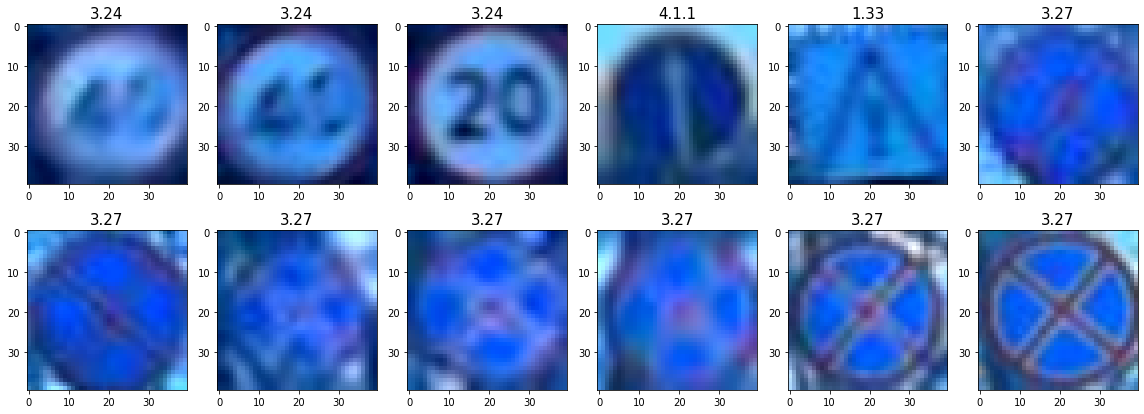

In [206]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import PadIfNeeded
from albumentations.augmentations.geometric.resize import LongestMaxSize


img_size = 40

minimal_transform = A.Compose(
        [
        LongestMaxSize(
            img_size,
            interpolation=cv2.INTER_AREA  
        ),
        PadIfNeeded(
            img_size, 
            img_size, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0
        ),
        ToTensorV2(),
        ]
    )

class SignDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, set_label=None, hyp=None, transform=None, alpha_color=None):
        self.transform = transform
        self.df = df[df['set'] == set_label] if set_label else df        
        self.hyp = hyp
        self.alpha_color = alpha_color
    
    def __len__(self):
        return len(self.df.index)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        label = int(row['encoded'])
        path = str(row['filepath'])
        sign = str(row['sign'])
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        
        # check does it contains transparent channel
        if img.shape[2] == 4:
            # randomize transparent
            trans_mask = img[:, :, 3] == 0
            img[trans_mask] = [self.alpha_color if self.alpha_color else random.randrange(0, 256),
                               self.alpha_color if self.alpha_color else random.randrange(0, 256),
                               self.alpha_color if self.alpha_color else random.randrange(0, 256),
                               255]

            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        # /randomize transparent

        # augment 
        if self.transform:
            img = self.transform(image=img)['image']
        # /augment
        
        img = img / 255
        return img, label, (path, sign)

train_dataset = SignDataset(RTDS_DF, 
                            set_label='train', 
                            transform=minimal_transform, 
                            hyp=None,
                            alpha_color=144
                           )

valid_dataset = SignDataset(RTDS_DF, 
                            set_label='test',  
                            transform=minimal_transform, 
                            hyp=None,
                            alpha_color=144
                           )

nrows, ncols = 70, 6
fig = plt.figure(figsize = (16,200))

for idx, (img, encoded_label, (path, sign)) in enumerate(valid_dataset):
    if idx + 1 > 12:
        break
    img = torch.Tensor.permute(img, [1, 2, 0]).numpy() 
    ax = fig.add_subplot(nrows, ncols, idx+1)
        
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect=1)
    ax.set_title(str(sign), fontsize=15)
    
plt.tight_layout()

In [223]:
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader


def getDataLoaderFromDataset(dataset, batch_size=8, shuffle=False, drop_last=False):
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=shuffle,
        drop_last=drop_last
    )
    return loader


@torch.no_grad()
def simpleGetAllEmbeddings(model, dataset, batch_size, dsc=''):
    dataloader = getDataLoaderFromDataset(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
    )
    print(len(dataloader.dataset))

    s, e = 0, 0
    pbar = tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        position=0,
        leave=False,
        desc='Getting all embeddings...' + dsc)
    
    info_arr = []
    add_info_len = None

    for idx, (data, labels, info) in pbar:
        data = data.to(device)
        q = model(data)

        if labels.dim() == 1:
            labels = labels.unsqueeze(1)
        if idx == 0:
            labels_ret = torch.zeros(
                len(dataloader.dataset),
                labels.size(1),
                device=device,
                dtype=labels.dtype,
            )
            all_q = torch.zeros(
                len(dataloader.dataset),
                q.size(1),
                device=device,
                dtype=q.dtype,
            )

        info = np.array(info)
        if add_info_len == None:
            add_info_len = info.shape[0]

        info_arr.extend(info.T.reshape((-1, add_info_len)))
        e = s + q.size(0)
        all_q[s:e] = q
        labels_ret[s:e] = labels
        s = e

    labels_ret = labels_ret.squeeze(1)
    print(labels_ret)
    print('!', len(labels_ret.unique()))
    all_q = torch.nn.functional.normalize(all_q)
    return all_q, labels_ret, info_arr


In [224]:
batch_size = 3600
num_workers = 8

encoder.eval()
train_embeddings, train_labels, train_additional_info = simpleGetAllEmbeddings(
    encoder, train_dataset, batch_size, ' for train'
)

test_embeddings, test_labels, test_additional_info = simpleGetAllEmbeddings(
    encoder, valid_dataset, batch_size, ' for test'
)
assert False


print('Test labels:', test_labels.unique(), 'len:', len(test_labels.unique()))
print('Train labels:', train_labels.unique(), 'len:', len(train_labels.unique()))


32760


Getting all embeddings... for train:   0%|          | 0/10 [00:00<?, ?it/s]

tensor([45, 45, 55,  ..., 30, 31, 32], device='cuda:0')
! 31
51292


Getting all embeddings... for test:   0%|          | 0/15 [00:00<?, ?it/s]

tensor([45, 45, 45,  ..., 32, 30, 32], device='cuda:0')
! 31


AssertionError: 

In [228]:
print(len(set(RTDS_DF[RTDS_DF['set']=='train']['encoded'])))

31


In [202]:
print(len(set(RTDS_DF[RTDS_DF['set']=='test']['sign'])))
print(len(set(RTDS_DF[RTDS_DF['set']=='train']['sign'])))

print(len(set(RTDS_DF[RTDS_DF['set'] == 'test']['encoded'])))
print(len(set(RTDS_DF[RTDS_DF['set'] == 'train']['encoded'])))

print(len(set(RTDS_DF[RTDS_DF['set']=='test'].index)))
print(len(RTDS_DF[RTDS_DF['set']=='train'].index))

print(len(set(RTDS_DF[RTDS_DF['set']=='test'].index)))
print(len(RTDS_DF[RTDS_DF['set']=='train'].index))

33
33
51292
32760
51292
32760


### Выше все ок, тестовый набор содержит тест+валид, который сформирован ноутбуков *RTSD-R_MERGED.ipynb*. В валид попало много знаков пешеходного перехода, т.к. их количество значительно превосходило остальные.

## Get Centroids

In [151]:
INVERSED_LABEL_DICT = {v: k for k, v in LABEL_DICT.items()}

In [152]:
len(labels_set)


31

In [153]:
labels_list = train_labels.cpu().numpy()
labels_set = list(set(labels_list))

embeddingsListForCentroids = train_embeddings.cpu().numpy()
centroidLocationDict = {}

p = tqdm(labels_set)
for label in p:
    p.set_description(
        f'Current label: {label} [{INVERSED_LABEL_DICT[label]}]'
    )
    mask = labels_list == label
    
    currentLabelEmbeddingsForCentroids = embeddingsListForCentroids[mask]
    zipped = list(zip(*currentLabelEmbeddingsForCentroids))
    
    singleCoord = []
    for coord in zipped:
        coord = sum(coord) / len(coord)
        singleCoord.append(coord)
        # print(coord)
        
    centroidLocationDict[label] = singleCoord

print('Getting centroids done.')

  0%|          | 0/31 [00:00<?, ?it/s]

Getting centroids done.


In [154]:
len(labels_set)


31

### lets construct plot DataFrame
Фундаментальный вопрос. fit PCA надо делать на train или на train+test?

In [155]:
from sklearn.decomposition import PCA
dim3 = True

print('Constructing dataframe for plotting.')

coords = ['x', 'y'] + (['z'] if dim3 else [])
columns = [*coords, 'type', 'size', 'sign', 'filepath', 'color', 'marker']

plot_df = pd.DataFrame(columns=columns)

reducer = PCA(
    n_components=3 if dim3 else 2, 
    random_state=RANDOM_STATE
)

train_size = 2
train_type = 'train'

test_size = 2
test_type = 'test'

centroid_size = 10
centroid_type = 'centroid'


## FIT REDUCER
train_embeddings_ = reducer.fit_transform(train_embeddings.cpu().numpy())

from itertools import cycle
import plotly.express as px
palette = cycle(
        [*px.colors.qualitative.Dark24, 
         *px.colors.qualitative.Alphabet, 
         *px.colors.qualitative.Light24]
    )
colorDict = {}

listOfRows = []
## CENTROIDS
for k, v in tqdm(centroidLocationDict.items()):
    coords = reducer.transform(np.array(v).reshape(1, -1)).flatten()
    # print([*coords, centroid_type, centroid_size, INVERSED_LABEL_DICT[k]])
    # print('Getting any for', INVERSED_LABEL_DICT[k])
    path = RTDS_DF[RTDS_DF['sign'] == INVERSED_LABEL_DICT[k]]['filepath'].values[0]
        
    colorDict[INVERSED_LABEL_DICT[k]] = next(palette)
    
    row = pd.Series(
        [*coords, centroid_type, centroid_size, INVERSED_LABEL_DICT[k], path, 
         colorDict[INVERSED_LABEL_DICT[k]], 'diamond'],
        index=plot_df.columns,
    )
    listOfRows.append(row)
    assert False
    
## TRAIN
for idx, (coord, label, info) in tqdm(
    enumerate(
        zip(train_embeddings_, train_labels, train_additional_info)),
    total=len(train_labels)
):
    label = label.cpu().numpy()
    
    color = colorDict[INVERSED_LABEL_DICT[int(label)]]
    
    row = pd.Series(
        [*coord, train_type, train_size, INVERSED_LABEL_DICT[int(label)], info[0], 
         colorDict[INVERSED_LABEL_DICT[k]], 'circle'],
        index=plot_df.columns,
    )
    listOfRows.append(row)


## TEST
test_embeddings_ = reducer.transform(test_embeddings.cpu().numpy())

for idx, (coord, label, info) in tqdm(
    enumerate(
        zip(test_embeddings_, test_labels, test_additional_info)),
    total=len(test_labels)
):
    label = label.cpu().numpy()
    
    row = pd.Series(
        [*coord, test_type, test_size, info[1], info[0], 
        colorDict[INVERSED_LABEL_DICT[k]], 'circle'],
        index=plot_df.columns,
    )
    
    listOfRows.append(row)

plot_df = pd.concat([plot_df, pd.DataFrame(listOfRows)], axis=0)
plot_df['x'] = plot_df['x'].astype(float)
plot_df['y'] = plot_df['y'].astype(float)
if 'z' in plot_df.columns:
    plot_df['z'] = plot_df['z'].astype(float)
    
plot_df['size'] = plot_df['size'].astype(int)

Constructing dataframe for plotting.


  0%|          | 0/31 [00:00<?, ?it/s]

AssertionError: 

In [ ]:
len(centroidLocationDict)

In [ ]:
sum(reducer.explained_variance_ratio_)

In [ ]:
set(plot_df_['type'])


In [ ]:
import plotly.express as px
from itertools import cycle

PLOT_CENTROID_AND_TEST_ONLY = True
PLOT_LIMIT_FRAC = 0.6

if PLOT_CENTROID_AND_TEST_ONLY:
    plot_df_ = plot_df[plot_df['type'] != 'train'][::-1]
else:
    plot_df_ = plot_df[::-1]

if PLOT_LIMIT_FRAC:
    plot_df_ = plot_df_.groupby(['sign', 'type']).sample(frac=PLOT_LIMIT_FRAC)

from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
import base64

app = JupyterDash(__name__)

@app.callback(
    Output("graph-tooltip-5", "show"),
    Output("graph-tooltip-5", "bbox"),
    Output("graph-tooltip-5", "children"),
    Input("graph-5", "hoverData"),
)
def display_hover(hoverData):

    if hoverData is None:
        return False, no_update, no_update

    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    num = hover_data["pointNumber"]
    data = hover_data['customdata']
    sign = data[0]
    rel_img_path = data[1]
    
    try:
        with open(rel_img_path, 'rb') as f:
            image = f.read()
    except FileNotFoundError as exc_obj:
        print(data)
        return False, no_update, no_update
    
    b64sed_image = 'data:image/png;base64,' + base64.b64encode(image).decode('utf-8')

    children = [
        html.Div([
            html.Img(
                src=b64sed_image,
                style={"width": "70px", 'display': 'block', 'margin': '0 auto'},
            ),
            html.P(sign, style={"fontSize": 14, 'text-align':'center'}),
            html.P(rel_img_path, style={"fontSize": 10}),
        ])
    ]
    return True, bbox, children

dim3 = True
plot_args = {
    'x': 'x',
    'y': 'y',
    'color': 'sign',
    'size': 'size',
    'opacity': 0.2 if dim3 else 0.5,
    'symbol': 'type',
    'hover_name': 'sign',
    'hover_data': ['sign', 'filepath', 'type'],
    'animation_group': 'type',
    'color_discrete_sequence': [
        *px.colors.qualitative.Dark24, 
        *px.colors.qualitative.Alphabet, 
        *px.colors.qualitative.Light24
    ]
}

if dim3:
    plotFcn = px.scatter_3d
    plot_args.update({'z': 'z'})
else:
    plotFcn = px.scatter
      
fig = plotFcn(
        plot_df_,
        **plot_args,

    )

fig.update_traces(
        hoverinfo="none", 
        hovertemplate=None,
        marker=dict(
            line=dict(
                width=0)
           )
)
    
fig.update_layout(
        width=950,
        height=950)

## FIX Z-ORDER
if True:
    sampleData = list(fig.data)
    centroidsList = []
    for t in list(sampleData[:]):
        if (t.ids[0] == 'centroid'):
            temp_t = t
            sampleData.remove(t)
            temp_t['marker']['opacity'] = 1
            temp_t['text'] = temp_t['customdata'][0][0]
            temp_t['textposition'] = 'top center'
            temp_t['mode'] = 'markers+text'
            temp_t['marker']['line']['width'] = 40 if dim3 else 2
            temp_t['marker']['line']['color'] = 'rgb(0, 0, 0)'
            centroidsList.append(temp_t)
            
    fig.data = tuple(sampleData + centroidsList)
    
fig.update_layout(font=dict(size=18))

app.layout = html.Div(
            className="container",
            children=[
                dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
                dcc.Tooltip(id="graph-tooltip-5", direction='bottom'),
            ],
        )
    
if __name__ == '__main__':
    app.run_server(mode='inline', debug=True, port=2002)

In [ ]:
def getEulerDistance(a, b):
    squares = [(p-q) ** 2 for p, q in zip(a, b)]
    return sum(squares) ** .5
    
distancesSign = {}

centroidSignList = list(centroidLocationDict.keys())
# print(centroidSignList)
for idx, ikey in enumerate(centroidSignList):
    distancesSign[INVERSED_LABEL_DICT[ikey]] = {}
    
    
    distancesSign[INVERSED_LABEL_DICT[ikey]][INVERSED_LABEL_DICT[ikey]] = np.NaN
    for jdx, jkey in enumerate(centroidSignList[idx + 1:]):
        dist = getEulerDistance(
            centroidLocationDict[ikey],
            centroidLocationDict[jkey]
        )
        distancesSign[INVERSED_LABEL_DICT[ikey]][INVERSED_LABEL_DICT[jkey]] = dist
        
# distancesSign
distancesSign = pd.DataFrame.from_dict(distancesSign)
for i in range(len(distancesSign)):
    distancesSign.iloc[i] = distancesSign.iloc[:, i]


In [ ]:
figH = px.imshow(distancesSign)
# fig.show()

app1 = JupyterDash(__name__)

PATH_PREFIX = '../data/STOCK_SIGNS/'
PATH_POSTFIX = '.png'

@app1.callback(
    Output("graph-tooltip-5", "show"),
    Output("graph-tooltip-5", "bbox"),
    Output("graph-tooltip-5", "children"),
    Input("graph-5", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    hover_data = hoverData["points"][0]
    
    hover_data['x'] = '2.3.1' if hover_data['x'] == '2.3' else hover_data['x']
    hover_data['y'] = '2.3.1' if hover_data['y'] == '2.3' else hover_data['y']        
    hover_data['x'] = '3.18.1'  if hover_data['x'] == '3.18' else hover_data['x'] 
    hover_data['y'] = '3.18.1'  if hover_data['y'] == '3.18' else hover_data['y']
        
    x_img_path = PATH_PREFIX + hover_data['x'] + PATH_POSTFIX
    y_img_path = PATH_PREFIX + hover_data['y'] + PATH_POSTFIX
    
    try:
        with open(x_img_path, 'rb') as f:
            image1 = f.read()
        with open(y_img_path, 'rb') as f:
            image2 = f.read()
    except:
        print(hoverData)
        return False, no_update, no_update
    
    img1 = 'data:image/png;base64,' + base64.b64encode(image1).decode('utf-8')
    img2 = 'data:image/png;base64,' + base64.b64encode(image2).decode('utf-8')

    children = [
        html.Div([
            html.Img(
                src=img1,
                style={"width": "70px",  'margin': '0 auto'},
            ),
            html.Img(
                src=img2,
                style={"width": "70px",  'margin': '0 auto'},
            ),
            html.P(hover_data['x'] + ':' + hover_data['y'], style={"fontSize": 14, 'text-align':'center'}),
            html.P(str(hover_data['z']), style={"fontSize": 14, 'text-align':'center'}),
            
        ]),
    ]
    return True, hover_data["bbox"], children

figH.update_traces(hoverinfo="none", hovertemplate=None)
    
figH.update_layout(
        width=600,
        height=600)

app1.layout = html.Div(
    className="container",
        children=[
            html.Div(html.H2("Дистации между центроидами")),
            dcc.Graph(id="graph-5", figure=figH, clear_on_unhover=True),
            dcc.Tooltip(id="graph-tooltip-5", direction='bottom'),
            ],
    )

if __name__ == '__main__':
    app1.run_server(mode='inline', debug=True, port=2003)

## Confusion Matrix

* train_embeddings, train_labels, train_additional_info - в этих переменных вся инфа о тестовых картинках;
* centroidLocationDict - словарь центроидов
* getEulerDistance - функция эвклидова расстояния.

In [ ]:

centroidLocationDictGpu = {}
for key, item in centroidLocationDict.items():
    centroidLocationDictGpu[key] = torch.Tensor(item).to(device)

In [ ]:
a = torch.Tensor([1, 1, 1])
b = torch.Tensor([[1, 1, 1], [1, 2, 3], [2, 2, 2]])
print(a - b)
print((a - b).pow(2))
print((a - b).pow(2).sum(-1))
print((a - b).pow(2).sum(-1).sqrt())

In [ ]:
list(zip(centroidLocationDictGpu.items()))


In [ ]:
# %%prun -s cumulative

sign_set = sorted(set(RTDS_DF['sign']))
v = {v: 0 for v in sign_set}
cf_dict = {k: v for k in sign_set}

CHECK_TRAIN = False
embs = train_embeddings if CHECK_TRAIN else test_embeddings
labels_per_embeddings = train_labels if CHECK_TRAIN else test_labels
labels_per_embeddings = labels_per_embeddings.cpu().tolist()

centroid_index_to_key = {index: val for index, val in enumerate(centroidLocationDictGpu.keys())}
centroid_locations = [centroidLocationDictGpu[label] for _, label in centroid_index_to_key.items()]
print(len(centroid_locations))
assert False
for i, emb in tqdm(
    enumerate(embs),
    total=len(embs)
    ):
    minDist = 999999
    closerVal = -1
    
    dist = (emb - centroid_locations).pow(2).sum(-1).sqrt()
    key = torch.argmin(dist)
    key = centroid_index_to_key[key]
    
    realSign = INVERSED_LABEL_DICT[labels_per_embeddings[i]]
    predictedSign = INVERSED_LABEL_DICT[key]
    # print('for', realSign, 'predicted', predictedSign)
            
    cf_dict[realSign][predictedSign] += 1


In [ ]:
centroidLocationDictGpu


In [ ]:
cfDf = pd.DataFrame(columns=sorted(set(RTDS_DF.sign)),
                    index=sorted(set(RTDS_DF.sign))
                   )
for read_sign, predicted_signs in cfDict.items():
    for predicted_sign, val in predicted_signs.items():
        cfDf.loc[read_sign][predicted_sign] = val

cfDf = cfDf.T
cfDf.fillna(0, inplace=True)

SHOILD_I_NORMOLIZE = True
if SHOILD_I_NORMOLIZE:
    cfDf = cfDf.apply(lambda x: x / x.sum())

In [ ]:
cfDf[:][10:30]

In [ ]:
cfDf.loc['1.31']

In [ ]:
figCf = px.imshow(cfDf.apply(lambda x: x / x.sum(), axis=1), color_continuous_scale=px.colors.sequential.Cividis_r)

app2 = JupyterDash(__name__)

PATH_PREFIX = '../data/STOCK_SIGNS/'
PATH_POSTFIX = '.png'

@app2.callback(
    Output("graph-tooltip-5", "show"),
    Output("graph-tooltip-5", "bbox"),
    Output("graph-tooltip-5", "children"),
    Input("graph-5", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    hover_data = hoverData["points"][0]
    sum_x = sum(map(int, cfDict[hover_data['y']].values()))
    
    if not hover_data['z']:
        return False, no_update, no_update
    
    hover_data['x'] = '2.3.1' if hover_data['x'] == '2.3' else hover_data['x']
    hover_data['y'] = '2.3.1' if hover_data['y'] == '2.3' else hover_data['y']        
    hover_data['x'] = '3.18.1'  if hover_data['x'] == '3.18' else hover_data['x'] 
    hover_data['y'] = '3.18.1'  if hover_data['y'] == '3.18' else hover_data['y']
    hover_data['x'] = '3.25.10' if hover_data['x'] == '3.25' else hover_data['x']
    hover_data['y'] = '3.25.10' if hover_data['y'] == '3.25' else hover_data['y']         
    hover_data['x'] = '3.24.10' if hover_data['x'] == '3.24' else hover_data['x']
    hover_data['y'] = '3.24.10' if hover_data['y'] == '3.24' else hover_data['y']   
    
    x_img_path = PATH_PREFIX + hover_data['x'] + PATH_POSTFIX
    y_img_path = PATH_PREFIX + hover_data['y'] + PATH_POSTFIX
    
    bbox = hover_data["bbox"]
    
    try:
        with open(x_img_path, 'rb') as f:
            image1 = f.read()
        with open(y_img_path, 'rb') as f:
            image2 = f.read()
    except:
        # print(hoverData)
        return False, no_update, no_update
    
    img1 = 'data:image/png;base64,' + base64.b64encode(image1).decode('utf-8')
    img2 = 'data:image/png;base64,' + base64.b64encode(image2).decode('utf-8')

    children = [
        html.Div([
            html.Img(
                src=img1,
                style={"width": "70px",  'margin': '0 auto'},
            ),
            html.Img(
                src=img2,
                style={"width": "70px",  'margin': '0 auto'},
            ),
            html.P(hover_data['x'] + ':' + hover_data['y'], style={"fontSize": 14, 'text-align':'center'}),
            html.P(
                str(hover_data['z']) 
                + ': all:' + str(sum_x * hover_data['z']), 
                style={"fontSize": 14, 'text-align':'center'}
            ),
        ]),
    ]
    return True, bbox, children

figCf.update_traces(
        hoverinfo="none", 
        hovertemplate=None
)
    
figCf.update_layout(
        width=950,
        height=650)
# figCf['layout'].update(plot_bgcolor='green')
app2.layout = html.Div(
            className="container",
            children=[
                dcc.Graph(id="graph-5", figure=figCf, clear_on_unhover=True),
                dcc.Tooltip(id="graph-tooltip-5", direction='bottom'),
            ],
        )
    
#fig.show()
if __name__ == '__main__':
    app2.run_server(mode='inline', debug=True, port=2003)

Precision/F1

Значения precision находятся в матрице ниже. В строках - актульные значения, в столбцах точность/вероятность предсказывания соответсвующего знака.

In [ ]:
sum(RTDS_DF['sign'] == '1.31')

In [ ]:
cfDf['1.31']

In [ ]:
import traceback

TPdict = {}
FNdict = {}
FPdict = {}
TNdict = {}

cfDf = cfDf.T

for i, row in cfDf.iterrows():    
    try:
        if i not in cfDf[i]:
            TPdict[i] = 0
        else:
            TPdict[i] = cfDf[i][i]
        FNdict[i] = cfDf[i].sum() - TPdict[i]
        FPdict[i] = cfDf.loc[i].sum() - TPdict[i]
        TNdict[i] = cfDf.fillna(0).values.sum() - TPdict[i] - FNdict[i] - FPdict[i]
    except KeyError as exc_obj:
        print(traceback.format_exc())
        print('err for key', i)
cfDf = cfDf.T

In [ ]:
_sign = '1.31'
TPdict[_sign], FNdict[_sign], FPdict[_sign], TNdict[_sign]

In [ ]:
PrecisionDict = {}
RecallDict = {}
F1Dict = {}
SupportDict = {}
for i in TPdict.keys():
    PrecisionDict[i] = TPdict[i] / (TPdict[i] + FPdict[i])
    RecallDict[i] = TPdict[i] / (TPdict[i] + FNdict[i])
    F1Dict[i] = 2 / (1 / PrecisionDict[i] + 1 / RecallDict[i])
    SupportDict[i] = TPdict[i] + FNdict[i]

In [ ]:
columns = ['Precision', 'Recall', 'F1', 'Support']
metrics = {}

for i in zip(PrecisionDict.items(), RecallDict.items(), F1Dict.items(), SupportDict.items()):
    metrics[i[0][0]] = [i[0][1], i[1][1], i[2][1], i[3][1]]
    
metricsDf = pd.DataFrame().from_dict(metrics, orient='index')
metricsDf.columns = columns

In [ ]:
metricsDf.loc['1.31']

In [ ]:
metricsDf.to_excel('metrics3_24.xls', engine='xlsxwriter')

## [ошибка](https://colab.research.google.com/github/KevinMusgrave/pytorch-metric-learning/blob/master/examples/notebooks/TripletMarginLossMNIST.ipynb)
accuracies = accuracy_calculator.get_accuracy